In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim


from utils.utils_dataset import *
from utils.utils_unet import *
from utils.utils_training import *



In [2]:


root = '.'

# Retrieve data and include transformation operations
print('Retrieving Data')

train_path_images = root + '/datasets/training/images'
train_path_target = root + '/datasets/training/1st_manual'
train_path_mask = root + '/datasets/training/mask'
test_path = root + '/datasets/test/images'

# transformations

# alternative using Random Operations function
'''
train_transform = transforms.Compose([RandomOperations([RandomHorizontalFlip(p = 1),
                                                        RandomVerticalFlip(p = 1)],
                                                       weights = [.5, .5]),
                                      RandomRotate(degrees = 180),
                                      ToTensor()])
'''
train_transform = transforms.Compose([RandomHorizontalFlip(p = .5),
                                     RandomVerticalFlip(p = .5),
                                     RandomRotate(degrees = 180),
                                     ToTensor()])

test_transform = ToTensor()

# retrieve dataset
train_dataset = CustomDataset(image_root=train_path_images,
                              target_root=train_path_target,
                              mask_root=train_path_mask,
                              transform=train_transform)
test_dataset = CustomDataset(image_root=test_path,
                             transform = test_transform)


# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)


# Put data into dataloaders
print('Loading DataLoaders')

# batch sizes
train_batch_size = 1
val_batch_size = 1
test_batch_size = 1

# split into train and val
train_size = int(len(train_dataset) * .7)
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# load into dataloaders
train_loader = DataLoader(train_data, batch_size = train_batch_size, shuffle = False)
val_loader = DataLoader(val_data, batch_size = val_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False )

Retrieving Data
Device: cpu
Loading DataLoaders


Test Images

In [3]:
test_model = UNet(init_channels = 3,
            filters = 64,
            output_channels = 2,
            pool_mode = 'max',
            up_mode = 'upconv', 
            connection = 'cat',
            same_padding = True,
            use_batchnorm = True,
            conv_layers_per_block = 2
            )


In [4]:
test_model

UNet(
  (db1_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (db1_pool): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (db2_conv): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (db2_pool): S

In [5]:
import os
def load_model(model, path):
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model


In [6]:
path = 'models/epoch100/unet.pth'

In [7]:
test_model = load_model(test_model, path)

In [8]:
loss_fn = nn.BCELoss()
device = 'cpu'

Validating
/opt/anaconda3/envs/algo_trade/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Segmentation:  tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
Seg Max:  tensor(0.9996)
Seg Min:  tensor(0.)
Number of non 0's: tensor(454374)
Number of 0's:  tensor(205546)
GT:  tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 

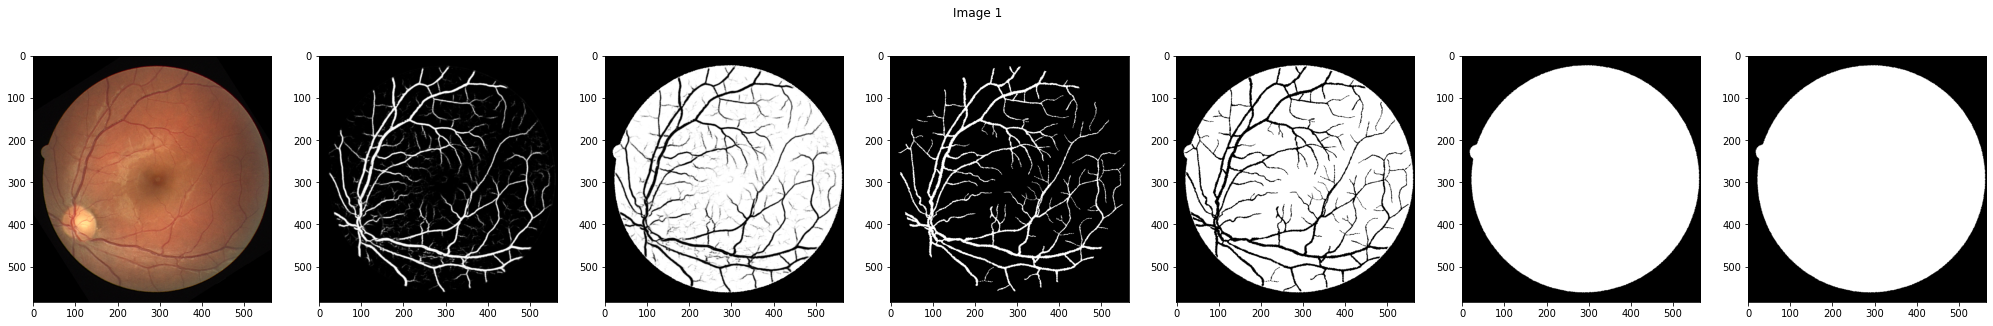

In [9]:
val_loss = val_epoch_test(epoch=0,
                     network=test_model,
                     loss_fn=loss_fn,
                     dataloader=val_loader,
                     device=device,
                     use_mask=True)

In [10]:

print(val_loss)

0.120992206
